In [1]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.utils
import PIL
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision import datasets
import d2l
from d2l import torch as d2l
from IPython import display
import datetime
import torch.nn.functional as F

In [2]:
conv = nn.Conv2d(3, 16 ,kernel_size = 3)#输入三通道，输出16通道，核大小3*3，步长1
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [4]:
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [5]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [6]:
#Downloading CIFAR-10
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) #下载太慢请开代理

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# 引入normalize的数据初始化
tensor_cifar10_normalize_train = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

tensor_cifar10_normalize_val = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

In [8]:
# Build the dataset and DataLoader

label_map = {0: 0, 2: 1} # 占位符
class_names = ['airplane', 'bird']
# 训练集
cifar2 = [(img, label_map[label])
    for img, label in tensor_cifar10_normalize_train
        if label in [0, 2]]
# 验证集
#cifar2_val = [(img, label_map[label])
#   for img, label in tensor_cifar10_normalize_val
#      if label in [0, 2]]

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape #图像像素从32*32缩减到30*30，丢了部分像素
# 32//3 = 2，边缘2像素被丢弃

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

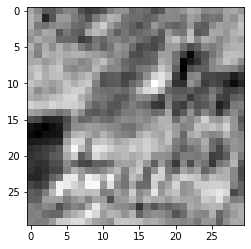

In [10]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [11]:
# 8.2.1 边缘填充
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)#引入padding
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [13]:
# 8.2.2 手动设置权重和bias
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

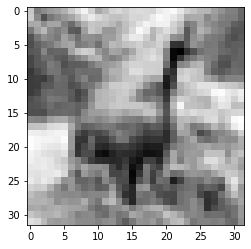

In [15]:
input = img.unsqueeze(0)

plt.imshow(input[0, 0].detach(), cmap='gray')
plt.show()

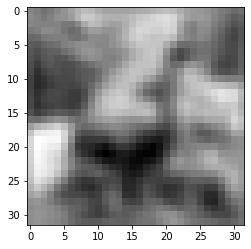

In [14]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

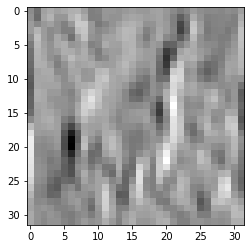

In [17]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [20]:
# max pooling
pool = nn.MaxPool2d(2) #下采样的一种
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

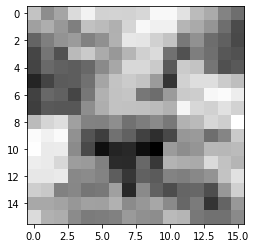

In [19]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [21]:
# 8.2.4 build the model

model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        # ...
        )

model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [23]:
model_final = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        # ...
        nn.Linear(8 * 8 * 8, 32),
        nn.Tanh(),
        nn.Linear(32, 2))

model_final

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [24]:
numel_list = [p.numel() for p in model_final.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
model_final(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [26]:
# 8.3.1 把网络定义成类

class Net(nn.Module):
    # super初始化
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    # 实现正向传播过程
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) #把8通道8*8的图片reshape成1*512
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
# 使用torch.nn.functional实现更简洁的定义网络的方法
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model2 = Net2()
numel_list = [p.numel() for p in model2.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [32]:
model(img.unsqueeze(0))

tensor([[-0.0137, -0.0332]], grad_fn=<AddmmBackward>)

In [33]:
model2(img.unsqueeze(0))

tensor([[-0.1321,  0.0858]], grad_fn=<AddmmBackward>)

In [34]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [35]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)

In [36]:
model = Net2() #
optimizer = optim.SGD(model.parameters(), lr=1e-2) #
loss_fn = nn.CrossEntropyLoss()

In [37]:
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,)

2021-10-19 15:47:41.762746 Epoch 1, Training loss 0.5723403191110891
2021-10-19 15:47:59.197505 Epoch 10, Training loss 0.324815277935593


In [39]:
# 验证集
cifar2_val = [(img, label_map[label])
   for img, label in tensor_cifar10_normalize_val
      if label in [0, 2]]

In [42]:
# 引入验证集
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [44]:
def validate(model, train_loader, val_loader):
    
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
    
validate(model, train_loader, val_loader)

Accuracy train: 0.86
Accuracy val: 0.86


In [45]:
# 8.4.2 保存加载模型
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [46]:
loaded_model = Net2()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>